In [1]:
# import statements
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import train_test_split

In [2]:
SPY_daily = yf.download('SPY')
energy_daily = yf.download('XLE')
materials_daily = yf.download('XLB')
industrial_daily = yf.download('XLI')
utilities_daily = yf.download('XLU')
health_daily = yf.download('XLV')
financial_daily = yf.download('XLF')
consumer_discretionary_daily = yf.download('XLY')
consumer_staples_daily = yf.download('XLP')
technology_daily = yf.download('XLK')
real_estate_daily = yf.download('VGSIX')
TYBonds_daily = yf.download('^TNX')
VIX_daily = yf.download('^VIX')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [12]:
def SMA(df, feature, window_size):
    new_col = 'MA' + feature + str(window_size)
    df[new_col] = df[feature].rolling(window=window_size).mean()
    return df

def Volitility(df, feature, window_size):
    new_col = 'VOLITILITY' + feature + str(window_size)
    returns = np.log(df[feature]/df[feature].shift())
    returns.fillna(0, inplace=True)
    df[new_col] = returns.rolling(window=window_size).std()*np.sqrt(window_size)
    return df

def RSI(df, feature, window_size):
    new_col = 'RSI' + feature + str(window_size)
    delta = df[feature].diff()
    delta = delta[1:]
    up, down = delta.clip(lower=0), delta.clip(upper=0)
    roll_up = up.rolling(window_size).mean()
    roll_down = down.abs().rolling(window_size).mean()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    df[new_col] = RSI
    return df

In [13]:
# get only close and volume from each DF


input_params = pd.DataFrame()

ticker_columns = [
    SPY_daily.Close, SPY_daily.Volume, 
    energy_daily.Close, energy_daily.Volume,
    materials_daily.Close, materials_daily.Volume,
    industrial_daily.Close, industrial_daily.Volume,
    utilities_daily.Close, utilities_daily.Volume, 
    health_daily.Close, health_daily.Volume,
    financial_daily.Close, financial_daily.Volume,
    consumer_discretionary_daily.Close, consumer_discretionary_daily.Volume,
    consumer_staples_daily.Close, consumer_staples_daily.Volume,
    technology_daily.Close, technology_daily.Volume,
    real_estate_daily.Close, real_estate_daily.Volume,
    TYBonds_daily.Close, TYBonds_daily.Volume,
    VIX_daily.Close, VIX_daily.Volume,
    ]

ticker_column_names = [
    "close_SPY"                        , "volume_SPY"                    ,
    "close_energy"                     , "volume_energy"                 ,
    "close_materials"                  , "volume_materials"              ,
    "close_industrial"                 , "volume_industrial"             ,
    "close_utilities"                  , "volume_utilities"              ,
    "close_health"                     , "volume_health"                 ,
    "close_financial"                  , "volume_financial"              ,
    "close_consumer_discretionary"     , "volume_consumer_discretionary" ,
    "close_consumer_staples"           , "volume_consumer_staples"       ,
    "close_technology"                 , "volume_technology"             ,
    "close_real_estate"                , "volume_real_estate"            ,
    "close_TYBonds"                    , "volume_TYBonds"                ,
    "close_VIX"                        , "volume_VIX"                    ,
]

# combine into one mega frame

input_params = pd.concat(ticker_columns, axis='columns')

input_params.columns = ticker_column_names

input_params = input_params.dropna()


In [8]:
# calculate technical indicators for 7, 20,50, and 200 day windows
for window_size in [7, 20, 50, 200]:
    for feature in ticker_column_names:
        input_params = SMA(input_params, feature, window_size)

input_params = input_params.dropna()

C:\Users\wujor\AppData\Local\Temp\ipykernel_38404\90966104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[feature].rolling(window=window_size).mean()
C:\Users\wujor\AppData\Local\Temp\ipykernel_38404\90966104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[feature].rolling(window=window_size).mean()
C:\Users\wujor\AppData\Local\Temp\ipykernel_38404\90966104.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [14]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

def get_3_barriers(daily_volatility, prices):
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)

    for day, vol in daily_volatility.items():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) and t_final != 0):
            vert_barrier = daily_volatility.index[days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
            days_passed, prices.loc[day], vert_barrier, \
            top_barrier, bottom_barrier

    return barriers

def get_labels(barriers):

    labels = []
    size = [] # percent gained or lossed 

    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= top_barrier).any()
            condition_sl = (barriers.price[start: end] <= bottom_barrier).any()
            #assign the labels
            if condition_pt: 
                labels.append(1)
            else: 
                labels.append(0)
            size.append((price_final - price_initial) / price_initial)
        else:
            labels.append(np.nan)
            size.append(np.nan)

    return labels, size

# how many days we hold the stock which set the vertical barrier
t_final = 10
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#align the index

vol_df = get_Daily_Volatility(input_params["close_SPY"])
prices = input_params["close_SPY"][vol_df.index]
barriers = get_3_barriers(vol_df, prices)
barriers.index = pd.to_datetime(barriers.index)
labs, size = get_labels(barriers) # training targets (???)
input_params = input_params[input_params.index.isin(barriers.index)]

2023-08-03 00:00:00
2023-08-18 00:00:00


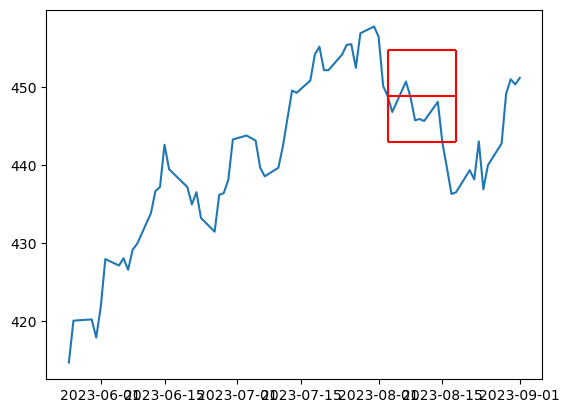

In [15]:
# test the box plotting thingy
plt.figure(999)
plt.plot(input_params["close_SPY"][-69:])
box = barriers.iloc[-22,:]
plt.vlines(box.name, ymin=box["bottom_barrier"], ymax=box["top_barrier"], colors="r")
plt.vlines(box["vert_barrier"], ymin=box["bottom_barrier"], ymax=box["top_barrier"], colors="r")
plt.hlines(box["top_barrier"], xmin=box.name, xmax=box["vert_barrier"], colors="r")
plt.hlines(box["price"], xmin=box.name, xmax=box["vert_barrier"], colors="r")
plt.hlines(box["bottom_barrier"], xmin=box.name, xmax=box["vert_barrier"], colors="r")
print(box.name)
print(box["vert_barrier"])

In [16]:
%%capture --no-stdout --no-display

def percentage_change(initial,final):
    return ((final - initial) / initial)

def expand_features(full_df):

    window = 5

    new_df = pd.DataFrame()
    for col in full_df.columns:
        print(col)
        if not col.startswith('label'):
            column = full_df[col]
            for i in range(1, window):
                shifted = column.shift(i)
                new_df['Shifted' + str(i) + col] = percentage_change(shifted, column)
        else:
            new_df[col] = full_df[col]

    return new_df

input_params = expand_features(input_params)

close_SPY
volume_SPY
close_energy
volume_energy
close_materials
volume_materials
close_industrial
volume_industrial
close_utilities
volume_utilities
close_health
volume_health
close_financial
volume_financial
close_consumer_discretionary
volume_consumer_discretionary
close_consumer_staples
volume_consumer_staples
close_technology
volume_technology
close_real_estate
volume_real_estate
close_TYBonds
volume_TYBonds
close_VIX
volume_VIX


In [19]:
# clean this shitshow of a dataframe
input_params = input_params.fillna(0).replace(np.inf,0)

In [29]:
#X_train, X_test, y_train, y_test = train_test_split(input_params, labs, test_size=0.33, random_state=42)
split_location = int(len(labs) * 0.88)
X_train = input_params.iloc[:split_location,:]
X_test = input_params.iloc[split_location:-t_final-1,:]
y_train = labs[:split_location]
y_test = labs[split_location:-t_final-1]
SEED = 42


In [33]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter  = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

classification_params = {'loss_function': 'Logloss',
          'eval_metric':'AUC',
          'early_stopping_rounds': 2,
          'verbose': 200,
          'random_seed': SEED
         }


model = CatBoostClassifier(**classification_params)
#model.fit(X_train, y_train,
#        eval_set=(X_test, y_test), 
#        use_best_model=True, )

cat_features = [0]

cv_dataset = Pool(data=X_train.astype(str),
                  label=y_train,
                  cat_features=cat_features)

cv_results = cv(cv_dataset,
            classification_params,
            fold_count=5, 
            plot="True")

print_cv_summary(cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	test: 0.5720396	best: 0.5720396 (0)	total: 53.1ms	remaining: 53s

bestTest = 0.6041759032
bestIteration = 7

Training on fold [1/5]
0:	test: 0.5525517	best: 0.5525517 (0)	total: 46.8ms	remaining: 46.7s

bestTest = 0.5990005216
bestIteration = 14

Training on fold [2/5]
0:	test: 0.5476284	best: 0.5476284 (0)	total: 44ms	remaining: 44s

bestTest = 0.5783407497
bestIteration = 11

Training on fold [3/5]
0:	test: 0.6028401	best: 0.6028401 (0)	total: 43ms	remaining: 43s

bestTest = 0.6132230987
bestIteration = 1

Training on fold [4/5]
0:	test: 0.5692557	best: 0.5692557 (0)	total: 43.2ms	remaining: 43.1s

bestTest = 0.6236734763
bestIteration = 13

Best validation Logloss score : 0.6852±0.0029 on step 16


In [ ]:
# train model

# display metrics